<a href="https://colab.research.google.com/github/vksyr/IST718/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

import pandas as pd



from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD


In [0]:
# Dataset was converted to CSV with this script: 
# https://pjreddie.com/projects/mnist-in-csv/
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/content/drive/My Drive/IST718/HW3/train-images-idx3-ubyte", "/content/drive/My Drive/IST718/HW3/train-labels-idx1-ubyte",
        "/content/drive/My Drive/IST718/HW3/mnist_train.csv", 60000)
convert("/content/drive/My Drive/IST718/HW3/t10k-images-idx3-ubyte", "/content/drive/My Drive/IST718/HW3/t10k-labels-idx1-ubyte",
        "/content/drive/My Drive/IST718/HW3/mnist_test.csv", 10000)

In [0]:
# create pandas df
cols = np.array(['label'])
for i in range(1,785):
  cols = np.append(cols, ['pixel' + str(i)])

train_images = pd.read_csv('/content/drive/My Drive/IST718/HW3/mnist_train.csv', 
                          header=None, names=cols)
test_images = pd.read_csv('/content/drive/My Drive/IST718/HW3/mnist_test.csv', 
                          header=None, names=cols)

In [0]:
'''
# plotting an image
import matplotlib.pyplot as plt
image = np.asarray(train_images.loc[0][1:]).squeeze()
plt.imshow(image)
plt.show()


# plotting an image
import matplotlib.pyplot as plt
image = np.asarray(data[0]).squeeze()
plt.imshow(image)
plt.show()
'''

Tensorflow

In [5]:
%tensorflow_version 1.x  #gpu
import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
# needs to be disabled for placeholder
# enabled for iteration

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  #gpu`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
'''
LABEL_COLUMN = 'label'
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      column_names = cols, 
      column_defaults = [0] * 785, 
      **kwargs)
  return dataset

raw_train_data = get_dataset('/content/drive/My Drive/IST718/HW3/mnist_train.csv')
raw_test_data = get_dataset('/content/drive/My Drive/IST718/HW3/mnist_test.csv')
'''

In [0]:
'''
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

#show_batch(raw_train_data)

# pack the data into a vector before passing it off to the model
# from https://www.tensorflow.org/tutorials/load_data/csv
class PackNumericFeatures(object):
  def __init__(self, names):
    self.names = names

  def __call__(self, features, labels):
    numeric_features = [features.pop(name) for name in self.names]
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features, labels


packed_train_data = raw_train_data.map(
    PackNumericFeatures(cols[1:]))

packed_test_data = raw_test_data.map(
    PackNumericFeatures(cols[1:]))

#example_batch, labels_batch = next(iter(packed_train_data)) 
'''

In [0]:
'''
import numpy as np

def next_batch(num, data, labels):

#    Return a total of `num` random samples and labels. 

    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


next_batch(batch_size, packed_train_data.batch(), packed_train_data)
'''

In [6]:
from tensorflow.examples.tutorials.mnist import input_data

# Read data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [7]:
image_size = 28
labels_size = 10
learning_rate = 0.05
steps_number = 1000
batch_size = 100

# Define placeholders
training_data = tf.placeholder(tf.float32, [None, image_size*image_size])
labels = tf.placeholder(tf.float32, [None, labels_size])

# Variables to be tuned
W = tf.Variable(tf.truncated_normal([image_size*image_size, labels_size], stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[labels_size]))

# Build the network (only output layer)
output = tf.matmul(training_data, W) + b

# Define the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=output))

# Training step
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Accuracy calculation
correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
# Run the training
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(steps_number):
  # Get the next batch
  input_batch, labels_batch = mnist.train.next_batch(batch_size)
  feed_dict = {training_data: input_batch, labels: labels_batch}

  # Run the training step
  train_step.run(feed_dict=feed_dict)

  # Print the accuracy progress on the batch every 100 steps
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict=feed_dict)
    print("Step %d, training batch accuracy %g %%"%(i, train_accuracy*100))

Step 0, training batch accuracy 9 %
Step 100, training batch accuracy 78 %
Step 200, training batch accuracy 85 %
Step 300, training batch accuracy 86 %
Step 400, training batch accuracy 89 %
Step 500, training batch accuracy 88 %
Step 600, training batch accuracy 85 %
Step 700, training batch accuracy 93 %
Step 800, training batch accuracy 87 %
Step 900, training batch accuracy 90 %


In [11]:
# Evaluate on the test set
test_accuracy = accuracy.eval(feed_dict={training_data: mnist.test.images, labels: mnist.test.labels})
print("Test accuracy: %g %%"%(test_accuracy*100)) # 89.83%

Test accuracy: 89.76 %


TF model was produced using two convolution layers

In [0]:
# WEIGHT INITIALIZATION
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# CREATE CONVOLUTION AND POOLING LAYERS
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# FIRST CONVOLUTION LAYER
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1]) # BASE IMAGE SIZE OF 28 * 28

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)  # RESULTING IMAGE SIZE IS 14 * 14

# SECOND CONOLUTION LAYER 
# MORE THAN ONE LAYER?  DEEP LEARNING
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#FULLY CONNECTED LAYER - BEFORE OUTPUT
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)  # ADD THE RECTIFIED LINEAR UNIT

# DROP LAYER - REDUCE OVERFITTING
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# LAST LAYER - OUTPUT
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [29]:
# RUN THE MODEL
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
  
  #43s on gpu, 0.9908 acc

step 0, training accuracy 0.06
step 100, training accuracy 0.84
step 200, training accuracy 0.92
step 300, training accuracy 0.98
step 400, training accuracy 1
step 500, training accuracy 0.92
step 600, training accuracy 1
step 700, training accuracy 0.98
step 800, training accuracy 0.92
step 900, training accuracy 0.96
step 1000, training accuracy 1
step 1100, training accuracy 0.96
step 1200, training accuracy 1
step 1300, training accuracy 0.98
step 1400, training accuracy 0.96
step 1500, training accuracy 0.98
step 1600, training accuracy 0.94
step 1700, training accuracy 0.96
step 1800, training accuracy 1
step 1900, training accuracy 1
step 2000, training accuracy 0.98
step 2100, training accuracy 0.94
step 2200, training accuracy 0.98
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 0.98
step 2600, training accuracy 0.98
step 2700, training accuracy 0.98
step 2800, training accuracy 1
step 2900, training accuracy 1
step 3000, training

CNN

In [0]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['acc'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_acc'], color='orange', label='test')
	pyplot.show()

def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

> 91.583
> 90.875
> 91.558
> 90.892
> 90.833


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

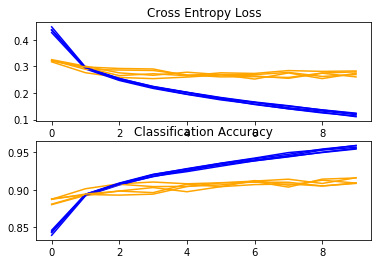

Accuracy: mean=91.148 std=0.346, n=5


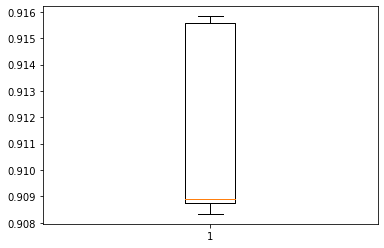

In [28]:
# run
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

# time: 1445s
# 91.148 std=0.346, n=5

> 91.417
> 91.250
> 90.858
> 90.742
> 91.075


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

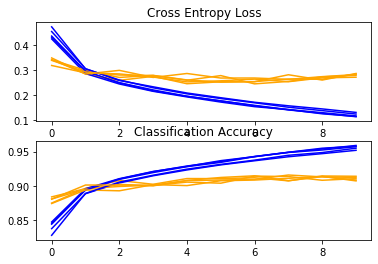

Accuracy: mean=91.068 std=0.247, n=5


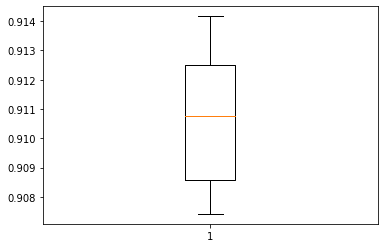

In [32]:
# add padded convolutions and rerun
# time: 1503s
# mean acc: 91.07

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

4423680/4422102 [==============================] - 0s 0us/step





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








> 90.517
> 91.250
> 90.950
> 91.583
> 91.575


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

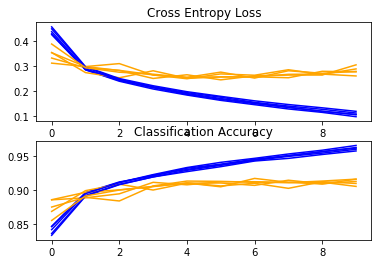

Accuracy: mean=91.175 std=0.404, n=5


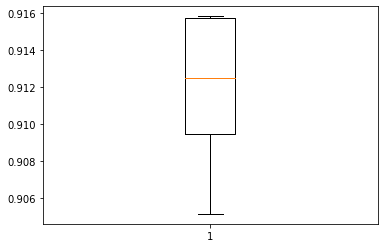

In [9]:
# add filters and rerun
def define_model():
	model = Sequential()
	model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

# 2397s cpu=none, 318s cpu=gpu
# mean acc: 91.175

In [0]:
'''
# MODEL
# CREATE PLACEHOLDER VARIABLES FOR OPERATION MANIPULATION
# THE 784 MATCHES THE VECTOR SIZE OF THE MNIST IMAGES - 28*28
x = tf.placeholder(tf.float32, [None, 784])

# MODEL
# CREATE WEIGHTS & BIASES VARIABLES
# IN TF, OUR MODEL PARAMETERS ARE OFTEN MANAGED AS VARIABLES
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# MODEL
# CREATE MODEL - USES SOFTMAX AS THE ACTIVATION FUNCTION
# REMEMBER GOAL FOR ACTIVATION FUNCTION IS TO "SHAPE" THE 
# OUTPUT INTO A PROBABILITY DISTRO OVER THE 10 CLASSES
y = tf.nn.softmax(tf.matmul(x, W) + b)

# MODEL
# CREATE PREDICTED VARIABLE Y-HAT
# AND USE CROSS ENTROPY TO DETERMINE LOSS
# CROSS ENTROPY - HOW INEFFICIENT ARE OUR PREDICTIONS?
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# MODEL
# TRAIN USING GRADIENT DESCENT
# LEARNING RATE AT MIDPOINT - .5 - MAKE SMALL ADJUSTMENTS TO MINIMIZE COST
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

'''